In [2]:
import numpy as np
import numpy.typing as npt
import scipy as sp
import sklearn
import sklearn.pipeline
import sklearn.metrics
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.base 


import econml.sklearn_extensions.linear_model as lin_model
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

### Estimating correlation/effect ("function connectivity" if you like that) from $P$ neurons to $1$

Notation:
- $N$ observations
- $M$ stimulus variables
- $P$ source/other neurons
- $\mathcal{A} \subseteq \{1,2,\dots,P\}$: the activate set of source neurons (non-zero connectivity)
- $|\mathcal{A}| = K \leq P$ active connections 
- $\mathbf{X}^s$: $\,N \times M$ stimulus matrix
- $\mathbf{X}^c$: $\,N \times P$ other neuron matrix
- $\mathbf{X}$: $\,N \times (P+M)$ given by $[\mathbf{X}^s, \mathbf{X}^c]$
- $\mathbf{Y}$: target neuron observations. Vector of length $N$


The underlying model we're considering is: simple linear-Gaussian.
For the $i$th observation:
$$
\mathbf{X}^{c}_{i} = \mathbf{X}^{s}_{i}\gamma_{s} + \nu_i \\
\mathbf{Y}_i = \mathbf{X}^{s}_{i}\beta_{s} + \mathbf{X}^{c}\beta_{c} + \epsilon_i \\
\mathbf{Y}_i = \mathbf{X}^{s}_{i}\beta_{s} + (\mathbf{X}^{s}_{i}\gamma_{s} + \nu_i)\beta_{c} + \epsilon_i \\
\mathbf{Y}_i = \mathbf{X}^{s}_{i}(\beta_{s} + \gamma_{s}\beta_{c}) + \nu_i\beta_{c} + \epsilon_i\\
\beta_{s*} = \beta_{s} + \gamma_{s}\beta_{c} \\
\mathbf{Y}_i = \mathbf{X}^{s}_{i}\beta_{s*} + \nu_i\beta_{c} + \epsilon_i\\
$$
- $\mathbf{X}^{s}_{i}$ is 0 mean Gaussian with $\Sigma_s$ ($M \times M$) correlation matrix (and covariance - diagonals are normalized to 1)
- $\nu_i$ is zero mean Gaussian with covariance $\Sigma_{\nu}$ ($P \times P$)
- $\epsilon_i$ is 0 mean Gaussian with variance $\sigma^2$.
- $\gamma_{s}$ is $M \times P$
- $\beta_{s}$ is $M \times 1$
- $\beta_{c}$ is $P \times 1$
- $\Sigma_{c} = \Sigma_{\nu} + \gamma_{s}^{\top} \Sigma_s \gamma_{s}$: the covariance of the source neurons
The final equation ($\mathbf{Y}_i = \mathbf{X}^{s}_{i}\beta_{s*} + \nu_i\beta_{c} + \epsilon_i$) is ideal: the covariates are separated into uncorrelated stimulus and input neuron noise. But we don't normally see this! We see the form with correlated stimulus and source neurons.

WLOG, we assume the mean of each column of $\mathbf{X}$ is $0$ and the mean of $\mathbf{Y}$ is 0.  
We assume the columns of $\mathbf{X^c}$,$\mathbf{X^s}$,$\mathbf{X}$, $\mathbf{X^*}$ (defined below), $\mathbf{X^{c*}}$ (defined below),and $\mathbf{Y}$ are all z-scored. 

We also consider estimates of the stimulus effect on each source neuron. As a linear estimate:
$\hat{\gamma}_{s} = (\mathbf{X}^{s\top}\mathbf{X}^s)^{-1}\mathbf{X}^{s\top}\mathbf{X^c}$. 

We then can take the activity of each neuron with the stimulus effect removed: $\mathbf{X}^* = \mathbf{X}^c - \mathbf{X}^s\hat{\gamma}_{s}$ and define
$\mathbf{X}^* = [\mathbf{X}^{s}, \mathbf{X}^{c*}]$. Therefore $\mathbf{X}^{c*}$ is an estimate of the noise in the source neurons, $\nu$, in the linear model.

We also consider the linear estimate of the stimulus on the target neuron:
$\hat{\beta}_{s} = (\mathbf{X}^{c\top}\mathbf{X}^s)^{-1}\mathbf{X}^{s\top}\mathbf{Y}$. 

The linear estimate of the source neurons on the target neuron:
$\hat{\beta}_{c} = (\mathbf{X}^{c\top}\mathbf{X}^c)^{-1}\mathbf{X}^{c\top}\mathbf{Y}$. 

The linear estimate of the source neurons minus their stimulus drive on the target neuron:
$\hat{\beta}_{c*} = (\mathbf{X}^{c*\top}\mathbf{X}^{c*})^{-1}\mathbf{X}^{c*\top}\mathbf{Y}$. 

The complete linear estimate for the target neuron :
$\hat{\beta}_{f} = (\mathbf{X}^{\top}\mathbf{X})^{-1}\mathbf{X}^{\top}\mathbf{Y}$. 

The complete linear estimate for the target neuron with the mean drive to the source neurons removed:
$\hat{\beta}_{f*} = (\mathbf{X}^{*\top}\mathbf{X}^*)^{-1}\mathbf{X}^{*\top}\mathbf{Y}$. 

In each simulation, we also control the signal strength each variable. 
- $S_{j,s} = 1-\text{var}(\mathbf{X}^{c}_{\cdot,j} - \mathbf{X}_s\gamma_{s,j})$: the fraction of variance of source neuron $j$ accounted for by the stimulus (linear effect only for now)
- $S_{s} = 1-\text{var}(\mathbf{Y}- \mathbf{X}^s\beta_{s})$ : the fraction of variance in the target neuron accounted for by the stimulus
- $S_{c} = 1-\text{var}(\mathbf{Y}- \mathbf{X}^c\beta_{c})$ : the fraction of variance in the target neuron accounted for by the source neurons
- $S_{c*} = 1-\text{var}(\mathbf{Y}- \mathbf{X}^{c*}\beta_{c*})$ : the fraction of variance in the target neuron accounted for by the source neurons with their mean stimulus drive removed

We then want to see how accurately we can determine the active set under different conditions. Different ways of viewing this estimation problem, while seemingly unimportant in the classic least-squares case, can impact data analysis pipelines when performing penalized estimation.

In [ ]:
'''
Scenario 1: equal impact of each active set.
Scan over : N, K, S_s, S_{c*}

How much are the source neurons impacted by the stimulus?
How much is the target neuron effected by the actual noise in the source neurons?
'''
rng = np.random.default_rng(seed=1234)
def generate_data(num_source_neurons=100,  num_active_source_neurons=20, num_stim_vars=8, num_observations=200, rng = np.random.default_rng()):
    P = num_source_neurons
    M = num_stim_vars
    N = num_observations
    K = num_active_source_neurons


    Sigma_nu = sp.stats.invwishart.rvs(df=P+1, scale=np.eye(P), random_state=rng)
    d = np.diag(Sigma_nu)[:,np.newaxis]
    Sigma_nu = Sigma_nu / (d @ d.T)
    Sigma_nu = np.eye(P)
    Sigma_s  = sp.stats.invwishart.rvs(df=M+1, scale=np.eye(M), random_state=rng)
    d = np.diag(Sigma_s)[:,np.newaxis]
    Sigma_s = Sigma_s / (d @ d.T)


    S_s      = 0.4
    S_c_star = 0.2
    S_js     = np.full((P),0.5)
    S_js     = rng.uniform(low=0.1,high=0.8,size=(P))

    sig2 = 1 - S_s - S_c_star
    sig = np.sqrt(sig2)


    sig_nu_ones = np.ones(K) @ (Sigma_nu[:K,:K] @ np.ones(K)) 

    beta_c_true = np.zeros((P))
    beta_c_true[:K] = np.sqrt(S_c_star / sig_nu_ones)

    beta_s_star_true = rng.normal(size=(M))
    beta_s_star_true *= np.sqrt(S_s / (beta_s_star_true @ (Sigma_s @ beta_s_star_true)))

    gamma_s_true = rng.normal(size=(M,P))
    pp = S_js*np.diag(Sigma_nu)/(1-S_js) 
    gamma_s_true *= np.sqrt(pp/np.diag(gamma_s_true.T @ (Sigma_s @ gamma_s_true)))[np.newaxis,:]

    beta_s_true = beta_s_star_true - gamma_s_true @ beta_c_true

    Sigma_c = Sigma_nu + gamma_s_true.T @ (Sigma_s @ gamma_s_true)

    # generate Nu, X^{c}, X^{s}, Y

    X_s = rng.multivariate_normal(mean=np.zeros(M), cov=Sigma_s, size=N)
    Nu = rng.multivariate_normal(mean=np.zeros(P), cov=Sigma_nu, size=N)
    eps = rng.normal(loc=0,scale=sig,size=(N))

    X_c = X_s @ gamma_s_true + Nu
    Y   = X_s @ beta_s_true + X_c @ beta_c_true + eps

    # X           = np.hstack([X_s,X_c])
    # X_star_true = np.hstack([X_s,Nu])
    return X_s, X_c, Y, beta_c_true, beta_s_true, beta_s_star_true


In [ ]:
def pick_fit(CV_scores,fits,return_idx=False):
    means =CV_scores.mean(axis=1)
    se = CV_scores.std(axis=1)/np.sqrt(CV_scores.shape[1])
    best = np.max(means)
    idx = np.where(means+se >= best)[0][-1]
    fit = fits[idx,:]
    if(return_idx):
        return fit, idx
    else:
        return fit

def scan_plot(CV_scores, fits, alphas, num_active_source_neurons=None, num_stim_vars=None, true_fit=None):
    best_fit, fit_idx = pick_fit(CV_scores,fits,return_idx=True);
    best_alpha = alphas[fit_idx]

    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    if(num_active_source_neurons is not None and num_stim_vars is not None):
        plt.semilogx(alphas,fits[:,:num_stim_vars],color='black');
        plt.semilogx(alphas,fits[:,(num_active_source_neurons+num_stim_vars):], color='red');
        plt.semilogx(alphas,fits[:,num_stim_vars:(num_active_source_neurons+num_stim_vars)], color='green');
    else:
        plt.semilogx(alphas,fits);
    plt.semilogx([best_alpha,best_alpha],[np.min(fits),np.max(fits)],'k:')
    plt.xlabel("lambda")
    plt.ylabel("parameter weight")
    plt.title("weights")

    plt.subplot(1,3,2)
    ymax = np.max(best_fit)
    ymin = np.min(best_fit)
    if(true_fit is not None):
        ymax = np.max([ymax,np.max(true_fit)])
        ymin = np.min([ymin,np.min(true_fit)])

    if(num_active_source_neurons is not None and num_stim_vars is not None):
        plt.fill_between([-0.5, num_stim_vars-0.5], [ymax, ymax], [ymin,ymin],color='black', alpha=0.2)
        plt.fill_between([-0.5+num_stim_vars, num_stim_vars+num_active_source_neurons+-0.5], [ymax, ymax], [ymin,ymin],color='green', alpha=0.2)
    if(true_fit is not None):
        plt.plot(true_fit,color='black',alpha=0.5)

    plt.plot(best_fit)
    xx = np.arange(best_fit.size)
    pp = np.abs(best_fit) > 1e-15
    plt.scatter(xx[pp], best_fit[pp], linewidths=0.5, s=8, edgecolors='black')

    plt.xlabel("variable")
    plt.ylabel("weight")
    plt.title("best fit")

    plt.subplot(1,3,3)
    alphas_2 = np.tile(alphas[:,np.newaxis],(1,10))
    cv_2 = np.tile(np.arange(1,11,dtype=int)[np.newaxis,:], (alphas.size,1))
    cv_means = np.mean(CV_scores,axis=1)
    plt.title("cross validation")


    df = pd.DataFrame({"CV_scores":CV_scores.ravel(), "lambda" : alphas_2.ravel(), "fold" : cv_2.ravel()})
    sns.lineplot(data=df, x="lambda", y="CV_scores", errorbar='se')
    plt.semilogx([best_alpha,best_alpha],[np.min(cv_means),np.max(cv_means)],'k:')
    plt.xscale('log')

In [ ]:
alphas = np.logspace(-3,1,50)


num_active_neurons = 20
num_stim = 8

X_s, X_c, Y, *true_parameters = generate_data(num_active_source_neurons=num_active_neurons, num_stim_vars=num_stim)

cv_K = 10
true_fit=np.concatenate((true_parameters[1],true_parameters[0]))

In [ ]:
def fit_LASSO_sequence(alphas : npt.ArrayLike, Z : npt.ArrayLike, Y : npt.ArrayLike, pipe : sklearn.pipeline.Pipeline, Z_test : npt.ArrayLike = None, Y_test : npt.ArrayLike = None):
    model = pipe.named_steps['linear_model']
    CV_scores = np.zeros((alphas.size))
    fits = np.zeros((alphas.size, Z.shape[1]))
    prev_coef = None
    for ii, alpha in enumerate(alphas):
        model.penalized_model.alpha = alpha
        if(prev_coef is not None):
            model.coef_[:] = prev_coef

        pipe.fit(Z, Y)
        
        if(Z_test is not None and Y_test is not None):
            Y_test_predict = pipe.predict(Z_test)
            neg_mse = -np.mean(np.square(Y_test - Y_test_predict))
            CV_scores[ii] = neg_mse

        prev_coef = np.array(model.coef_)

        # get the linear weights like this to make sure nothing is weird about the transforms
        fits[ii,:] = pipe.predict(np.eye(Z.shape[1]))-pipe.predict(np.zeros((1,Z.shape[1])))

    if(Z_test is not None and Y_test is not None):
        return fits, CV_scores
    else:
        return fits
    
def fit_LASSO_base(X_s, X_c, Y, cv_K, alphas, scaler, regularize_stimulus = False):
    M = X_s.shape[1]
    Z = np.hstack([X_s,X_c])

    CV_scores = np.zeros((alphas.size, cv_K))
    cv_gen = sklearn.model_selection.KFold(cv_K).split(Z,Y)
    fold = 0
    for train,test in cv_gen:
        Z_train = Z[train,:]
        Y_train = Y[train]
        Z_test = Z[test,:]
        Y_test = Y[test]

        model_0    = sklearn.linear_model.Lasso(alpha=alphas[0],fit_intercept=True,warm_start=True)
        if(regularize_stimulus):
            model = model_0
        else:
            model      = lin_model.SelectiveRegularization(range(M), model_0, fit_intercept=True)
        pipe = sklearn.pipeline.Pipeline([('scaler', scaler), ('linear_model', model)])

        _, CV_scores[:,fold] = fit_LASSO_sequence(alphas, Z_train, Y_train, pipe, Z_test, Y_test)
        fold += 1

    # fit with all data
    model_0    = sklearn.linear_model.Lasso(alpha=alphas[0],fit_intercept=True,warm_start=True)
    if(regularize_stimulus):
        model = model_0
    else:
        model      = lin_model.SelectiveRegularization(range(M), model_0, fit_intercept=True)
    pipe = sklearn.pipeline.Pipeline([('scaler', scaler), ('linear_model', model)])
    fits = fit_LASSO_sequence(alphas, Z, Y, pipe)

    return fits, CV_scores

In [ ]:
class AdaptiveLassoTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, ridge_penalty : float = 1e-3, adaptive_lasso_exp : float = 0.5, ignore_M : int = 0, fit_intercept : bool = True):
        self.estimator = sklearn.linear_model.Ridge(ridge_penalty,fit_intercept=fit_intercept)
        self.adaptive_lasso_exp = adaptive_lasso_exp
        self.fit_intercept = fit_intercept
        self.ridge_penalty = ridge_penalty
        self.ignore_M = ignore_M

    def fit(self, X, y):
        if(y.ndim > 1 and y.shape[1] > 1):
            raise ValueError("This adaptive lasso is only for univariate regression models.")
        self.estimator.fit(X,y)

        self.scale = np.power(np.abs(self.estimator.coef_[np.newaxis,:]),self.adaptive_lasso_exp);
        self.scale[0,:self.ignore_M] = 1 

        return self

    def transform(self, X, y=None):
        
        return X*self.scale
    def inverse_transform(self, X, y=None):
        
        return X/self.scale
    
def fit_LASSO(X_s, X_c, Y, cv_K, alphas, regularize_stimulus = False):
    scaler = sklearn.preprocessing.StandardScaler()
    return fit_LASSO_base(X_s, X_c, Y, cv_K, alphas, scaler, regularize_stimulus=regularize_stimulus)

    
def fit_adaptLASSO(X_s, X_c, Y, cv_K, alphas, ridge_estimator_penalty=1e-3, adaptive_lasso_exp=1.0, regularize_stimulus=False):
    scaler = AdaptiveLassoTransformer(ridge_estimator_penalty, adaptive_lasso_exp)
    return fit_LASSO_base(X_s, X_c, Y, cv_K, alphas, scaler, regularize_stimulus=regularize_stimulus)

In [ ]:
fits, CV_scores = fit_LASSO(X_s, X_c, Y, cv_K, alphas)
scan_plot(CV_scores,fits,alphas,num_active_neurons,num_stim,true_fit)

In [ ]:
fits, CV_scores = fit_adaptLASSO(X_s, X_c, Y, cv_K, alphas)
scan_plot(CV_scores,fits,alphas,num_active_neurons,num_stim,true_fit)

In [3]:


def fit_EMVS_part(Z : npt.ArrayLike, Y : npt.ArrayLike, lambda_slab : float, lambda_spike : float,
                      M : int = 0,
                      beta_init : npt.ArrayLike = None, theta_init : float = None,
                      prior_theta_a : float = 1,
                      prior_theta_b : float = 1,
                      epsilon = 0.001, max_em_iters = 1000) -> tuple[npt.ArrayLike,float]:

    Z_c = np.array(Z)

    # def fit_SSL_EMV

    
    if(theta_init is None):
        theta_star = 0.5
    else:
        theta_star = theta_init

    if(beta_init is None):
        ridge_penalty = lambda_slab
        fit_intercept = True
        estimator = sklearn.linear_model.Ridge(ridge_penalty,fit_intercept=fit_intercept)
        estimator.fit(Z,Y)
        beta_init = np.array(estimator.coef_)

    beta_star = np.array(beta_init)

    
    P = beta_star.size - M
    diff = epsilon*2
    iters = 0

    while(diff > epsilon and iters < max_em_iters):
        # compute effective weights 
        # p_slab  =    theta_star *lambda_slab *np.exp(-lambda_slab*np.abs(beta_star[M:]))
        # p_spike = (1-theta_star)*lambda_spike*np.exp(-lambda_spike*np.abs(beta_star[M:]))
        # p_norm = (p_spike+p_slab)
        # p_slab  = p_slab/p_norm
        p_slab  =   1/(1 + np.sqrt(lambda_spike/lambda_slab)*(1-theta_star)*theta_star*np.exp(-np.square(beta_star[M:])*(lambda_spike - lambda_slab)))
        # p_spike = p_spike/p_norm
        # theta_star = (np.sum(p_slab) + prior_theta_a - 1)/(prior_theta_a + prior_theta_b + P - 2)

        lambda_star = p_slab*lambda_slab + (1-p_slab)*lambda_spike

        Z_c[:,M:] = Z[:,M:]/lambda_star[np.newaxis,:]
        beta_star_c = np.array(beta_star)
        beta_star_c[M:] *= lambda_star

        model_0    = sklearn.linear_model.Ridge(alpha=1,fit_intercept=True)
        if(M <= 0):
            model = model_0
        else:
            model      = lin_model.SelectiveRegularization(range(M), model_0, fit_intercept=True)


        # model.fit(Z_c,Y)
        model.coef_=beta_star_c
        model.intercept_ = 0

        model.fit(Z_c,Y)
        beta_star_new = model.predict(np.eye(Z.shape[1]))-model.predict(np.zeros((1,Z.shape[1])))

        beta_star_new[M:] /= lambda_star

        diff = np.linalg.norm(beta_star_new - beta_star)
        beta_star = beta_star_new
        iters += 1

    if(iters >= max_em_iters):
        print("Maximum EM iters reached before convergence.")
    # print(f"iters = {iters}, diff = {diff}")
    

    return beta_star, theta_star, p_slab, lambda_star, beta_init

def fit_SSL_EMVS_part(Z : npt.ArrayLike, Y : npt.ArrayLike, lambda_slab : float, lambda_spike : float,
                      M : int = 0,
                      beta_init : npt.ArrayLike = None, theta_init : float = None,
                      prior_theta_a : float = 1,
                      prior_theta_b : float = 1,
                      epsilon = 0.001, max_em_iters = 1000) -> tuple[npt.ArrayLike,float]:

    Z_c = np.array(Z)

    # def fit_SSL_EMV

    
    if(theta_init is None):
        theta_star = 0.5
    else:
        theta_star = theta_init

    if(beta_init is None):
        beta_star, theta_star, *_ = fit_EMVS_part(Z,Y,lambda_slab=lambda_slab,lambda_spike=lambda_spike,M=M, beta_init=beta_init, theta_init=theta_init,prior_theta_a=prior_theta_a,
                      prior_theta_b=prior_theta_b, epsilon=epsilon,max_em_iters=max_em_iters)
    else:
        beta_star = np.array(beta_init)

    
    P = beta_star.size - M
    diff = epsilon*2
    iters = 0

    while(diff > epsilon and iters < max_em_iters):
        # compute effective weights 
        # p_slab  =    theta_star *lambda_slab *np.exp(-lambda_slab*np.abs(beta_star[M:]))
        # p_spike = (1-theta_star)*lambda_spike*np.exp(-lambda_spike*np.abs(beta_star[M:]))
        # p_norm = (p_spike+p_slab)
        # p_slab  = p_slab/p_norm
        p_slab  =   1/(1 + lambda_spike/lambda_slab*(1-theta_star)/theta_star*np.exp(-np.abs(beta_star[M:])*(lambda_spike - lambda_slab)))
        # p_spike = p_spike/p_norm
        # theta_star = (np.sum(p_slab) + prior_theta_a - 1)/(prior_theta_a + prior_theta_b + P - 2)

        lambda_star = p_slab*lambda_slab + (1-p_slab)*lambda_spike

        Z_c[:,M:] = Z[:,M:]/lambda_star[np.newaxis,:]
        beta_star_c = np.array(beta_star)
        beta_star_c[M:] *= lambda_star

        model_0    = sklearn.linear_model.Lasso(alpha=1,fit_intercept=True,warm_start=True)
        if(M <= 0):
            model = model_0
        else:
            model      = lin_model.SelectiveRegularization(range(M), model_0, fit_intercept=True)


        # model.fit(Z_c,Y)
        model.coef_=beta_star_c
        model.intercept_ = 0

        model.fit(Z_c,Y)
        beta_star_new = model.predict(np.eye(Z.shape[1]))-model.predict(np.zeros((1,Z.shape[1])))

        beta_star_new[M:] /= lambda_star

        diff = np.linalg.norm(beta_star_new - beta_star)
        beta_star = beta_star_new
        iters += 1

    if(iters >= max_em_iters):
        print("Maximum EM iters reached before convergence.")
    # print(f"iters = {iters}, diff = {diff}")
    

    return beta_star, theta_star, p_slab, lambda_star, beta_init

In [ ]:
def fit_SSL_EMVS_sequence(Z : npt.ArrayLike, Y : npt.ArrayLike,  lambdas: npt.ArrayLike,
                      M : int,
                      prior_theta_a : float = 1,
                      prior_theta_b : float = 1,
                      epsilon = 0.0001, max_em_iters = 1000, lambda_slab = None,
                      beta = None, theta = None):
    fits = np.zeros((lambdas.size, Z.shape[1]))
    thetas = np.zeros(lambdas.size)
    p_slabs = np.zeros((lambdas.size,Z.shape[1] - M))


    if(lambda_slab is None):
        lambda_slab=lambdas[0]
    for ii, lambda_spike in enumerate(lambdas):
        beta, theta, p_slabs[ii,:], *_ = fit_SSL_EMVS_part(Z=Z, Y=Y, lambda_slab=lambda_slab, lambda_spike=lambda_spike,
                      M=M,
                      beta_init=beta, theta_init=theta,
                      prior_theta_a=prior_theta_a,
                      prior_theta_b=prior_theta_b,
                      epsilon=epsilon, max_em_iters=max_em_iters)
        thetas[ii] = theta
        fits[ii,:] = beta
    return fits, thetas, p_slabs

def fit_EMVS_sequence(Z : npt.ArrayLike, Y : npt.ArrayLike,  lambdas: npt.ArrayLike,
                      M : int,
                      prior_theta_a : float = 1,
                      prior_theta_b : float = 1,
                      epsilon = 0.0001, max_em_iters = 1000, lambda_slab = None,
                      beta = None, theta = None):
    fits = np.zeros((lambdas.size, Z.shape[1]))
    thetas = np.zeros(lambdas.size)
    p_slabs = np.zeros((lambdas.size,Z.shape[1] - M))

    
    

    if(lambda_slab is None):
        lambda_slab=lambdas[0]
    for ii, lambda_spike in enumerate(lambdas):
        beta, theta, p_slabs[ii,:], *_ = fit_EMVS_part(Z=Z, Y=Y, lambda_slab=lambda_slab, lambda_spike=lambda_spike,
                      M=M,
                      beta_init=beta, theta_init=theta,
                      prior_theta_a=prior_theta_a,
                      prior_theta_b=prior_theta_b,
                      epsilon=epsilon, max_em_iters=max_em_iters)
        thetas[ii] = theta
        fits[ii,:] = beta
    return fits, thetas, p_slabs



In [39]:
def fit_SSL_part(Z : npt.ArrayLike, Y : npt.ArrayLike, lambda_slab : float, lambda_spike : float,
                      M : int = 0,
                      beta_init : npt.ArrayLike = None, theta_init : float = None, sig2_init : float = None, mu_init : float = None,
                      prior_theta_a : float = 1,
                      prior_theta_b : float = 1,
                      epsilon = 0.001, max_iters = 1000,  M_ridge_penalty = 0):

    # def fit_SSL_EMV

    
    if(theta_init is None):
        theta_star = 0.5
    else:
        theta_star = theta_init
    if(mu_init is None):
        mu = np.mean(Y)
    else:
        mu = mu_init

    if(beta_init is None):
        ridge_penalty = lambda_slab
        fit_intercept = True
        estimator = sklearn.linear_model.Ridge(ridge_penalty,fit_intercept=fit_intercept)
        estimator.fit(Z,Y)
        beta_init = np.array(estimator.coef_)
        mu = estimator.intercept_
    
    beta_star = np.array(beta_init)

    if(sig2_init is None):
        sig2_init = np.mean((Z@beta_star - Y)**2)

    sig2 = sig2_init

    
    P = beta_star.size - M
    PF = beta_star.size
    diff = epsilon*2
    iters = 1

    n = Y.size
    ZZ = Z.T@Z
    ZZ_d = np.copy(ZZ)
    np.fill_diagonal(ZZ_d,0)
    ZY = Z.T@Y
    # YY = np.dot(Y,Y)
    # sum_Y = np.sum(Y)
    # sum_Z = np.sum(Z,axis=0)

    mu_Z = np.mean(Z,0,keepdims=True)
    mu_Y = np.mean(Y)

    while(diff > epsilon and iters <= max_iters):
        p_star_0_part = 1 + lambda_spike/lambda_slab*(1-theta_star)/theta_star
        log_p_star_0 = -np.log(p_star_0_part)
        p_star_0 = 1/p_star_0_part
        lambda_star_0 = lambda_slab*p_star_0 + lambda_spike*(1-p_star_0)
        g_theta_0 = (lambda_star_0  - lambda_slab)**2 + (2*n/sig2)*log_p_star_0

        if(g_theta_0 > 0):
            delta = np.sqrt(-2*n*sig2*log_p_star_0) + sig2*lambda_spike
        else:
            delta = sig2*lambda_star_0



        for jj in range(M,PF):
            z_j = (ZY[jj] - ZZ_d[[jj],:]@beta_star)[0]
            
            if(np.abs(z_j) > delta  ):
                p_slab_j  =   1/(1 + lambda_spike/lambda_slab*(1-theta_star)/theta_star*np.exp(-np.abs(beta_star[jj])*(lambda_spike - lambda_slab)))
                lambda_star_j = lambda_slab*p_slab_j + lambda_spike*(1-p_slab_j)

                if(np.abs(z_j) > lambda_star_j  ):
                    beta_star[jj] = 1/n*(np.abs(z_j) - lambda_star_j)*np.sign(z_j)
                else:
                    beta_star[jj] = 0
            else:
                beta_star[jj] = 0

        if(M > 0):
            fit_intercept = True
            estimator = sklearn.linear_model.Ridge(M_ridge_penalty,fit_intercept=fit_intercept)
            estimator.fit(Z[:,:M],Y - Z[:,M:]@beta_star[M:])
            beta_star[:,M] = estimator.coef_
            mu = estimator.intercept_
        else:
            mu = (mu_Y - mu_Z@beta_star)[0]

        p_slab  =   1/(1 + lambda_spike/lambda_slab*(1-theta_star)/theta_star*np.exp(-np.abs(beta_star[M:])*(lambda_spike - lambda_slab)))
        theta_star = (prior_theta_a + np.sum(p_slab))/(prior_theta_a+prior_theta_b+P)
        
        sse = np.sum((Y - Z@beta_star - mu)**2)
        # sse = YY - 2 * np.dot(ZY,beta_star) - 2*sum_Y*mu + beta_star[np.newaxis,:] @ ZZ @ beta_star + 2*mu*np.dot(sum_Z,beta_star) + mu**2 * n
        sig2 = sse/(n+2)

        iters += 1
    return beta_star, mu, sig2, theta_star

def fit_SSL_sequence(Z : npt.ArrayLike, Y : npt.ArrayLike,  lambdas: npt.ArrayLike,
                      M : int,
                      prior_theta_a : float = 1,
                      prior_theta_b : float = 1,
                      epsilon = 0.0001, max_iters = 1000, lambda_slab = None,
                      beta = None, theta = None, mu = None, sig2 = None):
    fits = np.zeros((lambdas.size, Z.shape[1]))
    thetas = np.zeros(lambdas.size)
    mus = np.zeros(lambdas.size)
    sig2s = np.zeros(lambdas.size)


    if(lambda_slab is None):
        lambda_slab=lambdas[0]
    for ii, lambda_spike in enumerate(lambdas):
        beta_star, mu, sig2, theta_star, *_ = fit_SSL_part(Z=Z, Y=Y, lambda_slab=lambda_slab, lambda_spike=lambda_spike,
                      M=M,
                      beta_init=beta, theta_init=theta, mu_init = mu, sig2_init = sig2,
                      prior_theta_a=prior_theta_a,
                      prior_theta_b=prior_theta_b,
                      epsilon=epsilon, max_iters=max_iters)
        thetas[ii] = theta_star
        mus[ii] = mu
        sig2s[ii] = sig2
        fits[ii,:] = beta_star
    return fits, mus, sig2s, thetas


In [65]:
alphas = np.logspace(-3,2,1000)
# alphas = np.linspace(0.01,50,200)
# alphas = np.array([0.1, 100,100])
# Z = np.hstack([X_s, X_c[:,:25]])
# M = X_s.shape[1]

lambda_slab = 0.001
lambda_spike = 1

N = 100
N2 = 10000

Z = np.random.randn(N,10)
b = np.zeros(10)
b[:2] = 0.1
Y = Z@b + np.random.randn(N)*1

Z2 = np.random.randn(N2,10)
Y2 = Z2@b + np.random.randn(N2)*1

M = 0

# Z=sp.stats.zscore(Z,axis=0)
# Y= sp.stats.zscore(Y)
# fits, theta,p_slabs = fit_SSL_EMVS_sequence(Z,Y,alphas,M=M,prior_theta_b=1,max_em_iters=100,lambda_slab=lambda_slab,theta=0.2)

b_est_1,*_ = np.linalg.lstsq(Z,Y,rcond=None)
print(b_est_1)
b_est_2,*_ = np.linalg.lstsq(Z[:,:2],Y,rcond=None)
print(b_est_2)

# fit_SSL_part(Z,Y,M=M,prior_theta_b=1,max_iters=100,lambda_slab=lambda_slab,lambda_spike=lambda_spike,theta_init=0.2)
fits, mus, sig2s, thetas = fit_SSL_sequence(Z,Y,M=M,prior_theta_b=1,max_iters=100,lambda_slab=lambda_slab,lambdas=alphas,theta=0.2)

[ 0.09909597  0.2396787   0.09914582 -0.07219214 -0.01810212  0.00263688
  0.06879658 -0.03241531  0.03042122 -0.00822427]
[0.11816094 0.25456743]


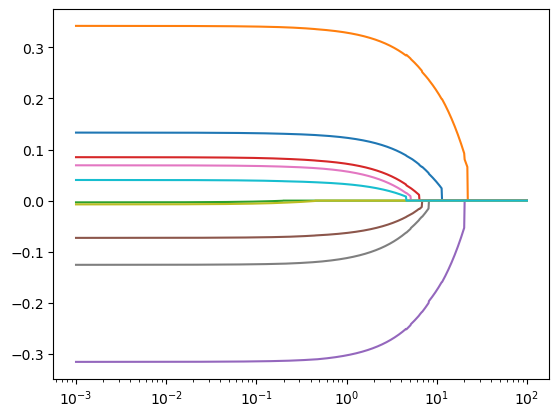

In [64]:
plt.semilogx(alphas,fits);


In [66]:
sses = np.zeros((alphas.size))
for ii in range(alphas.size):
    sses[ii] = np.mean(np.square(Y2 - Z2@fits[ii,:] - mus[ii]))

1.0491009010657848


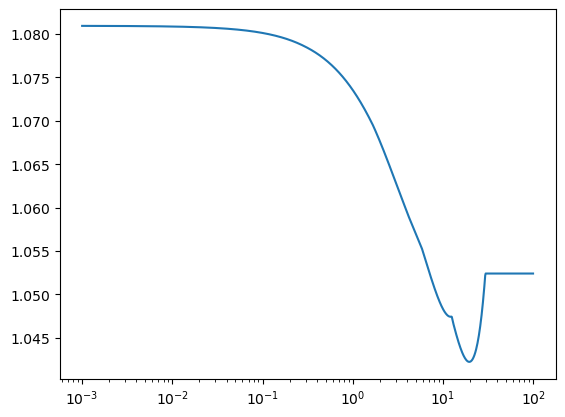

In [70]:
plt.semilogx(alphas,sses)
print(np.mean(np.square(Y2 - Z2@b_est_1)))